In [1]:
import getpass
import plotly.express as px
import plotly.io as pio
import time
import urllib.parse
import pandas as pd
import sqlalchemy


# Allow charts to persist between notebook sessions.
pio.renderers.default='notebook'

In [ ]:
edm_address = ""# getpass.getpass(prompt='EDM server address: ')
print(edm_address)
print('\nEDM login information')
edm_name = ""#getpass.getpass(prompt='Username: ')
edm_password = getpass.getpass(prompt='Password: ')
edm_password = urllib.parse.quote(edm_password)
%load_ext sql
%sql postgresql://$edm_name:$edm_password@$edm_address/edm
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False
print(edm_name, edm_password)
# Delete the credential variables for security purpose.
del edm_name, edm_password



EDM login information


C:\Users\Atika\AppData\Local\Temp\ipykernel_17268\2281614543.py:46: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '79565.57356810526' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



    index grid_element_id_upper terminal1_cn_upper terminal2_cn_upper  \
0     424                  2431           VCN.2135           VCN.2431   
1    1079             L17-57682      VCN.L17-57681      VCN.L17-57682   
2    1088             L17-57696      VCN.L17-57695      VCN.L17-57696   
3    1089             L17-57696      VCN.L17-57695      VCN.L17-57696   
4    1091             L17-57698      VCN.L17-57696      VCN.L17-57698   
5    1092             L17-57698      VCN.L17-57696      VCN.L17-57698   
6    1105             L17-57708      VCN.L17-57707      VCN.L17-57708   
7    1112             L17-57716      VCN.L17-57715      VCN.L17-57716   
8    1115             L17-57718      VCN.L17-57716      VCN.L17-57718   
9    1393             L17-57960      VCN.L17-57959      VCN.L17-57960   
10   1398             L17-57966      VCN.L17-57960      VCN.L17-57966   
11   1418             L17-57987      VCN.L17-57986      VCN.L17-57987   
12   1428             L17-57995      VCN.L17-57994 

C:\Users\Atika\AppData\Local\Temp\ipykernel_17268\2281614543.py:77: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Phase Loads Data:
   grid_element_id phase     total_kwh
0            17Y73     C  7.956557e+04
1             7242     C  1.162586e+05
2             6598     B  1.580005e+05
3       L17-146892     C  1.433002e+05
4       L17-138308     C  3.614272e+05
5       L17-138359     A  1.632713e+05
6       L17-136862     C  5.301194e+05
7       L17-136043     C  3.187857e+05
8        L17-57719     B  9.463201e+06
9       L17-137896     C  9.205374e+04
10      L17-136033     B  3.720312e+05
11      L17-136188     B  5.607920e+04
12       L17-84944     B  2.788813e+05
13      L17-137270     C  1.271109e+05
14           14405     B  9.078863e+04
15      L17-139349     C  4.942893e+05
16       L17-58026     A  3.357015e+06
17      L17-136410     A  2.674042e+05
18          118021     A  2.222707e+05
19          118184     A  8.220871e+04
20          118861     A  1.140174e+05
21       L17-58058     C  9.587821e+05
22      L17-137723     C  1.452381e+05
23      L17-135884     C  2.539725e+05
24     

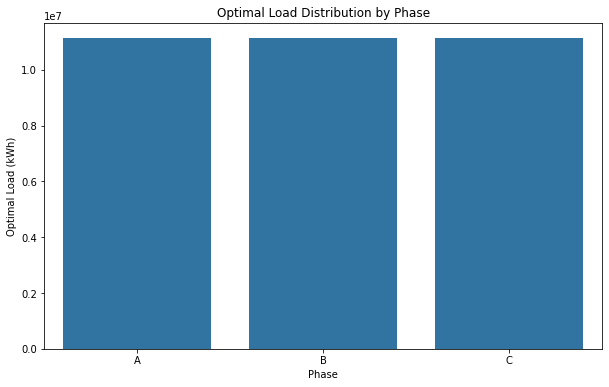

Load Differences:
 phase
A    6.444895e+06
B    4.936762e+05
C   -6.938570e+06
dtype: float64
Reassigned cluster L17-138359 from phase A to phase C
Reassigned cluster 6598 from phase B to phase C
Reassigned cluster L17-58026 from phase A to phase C
Reassigned cluster L17-136410 from phase A to phase C
Reassigned cluster 118021 from phase A to phase C
Reassigned cluster 118184 from phase A to phase C
Reassigned cluster 118861 from phase A to phase C
Reassigned cluster 11628 from phase A to phase C
Reassigned cluster L17-137897 from phase A to phase C
Improvement below threshold. Stopping reassignments.
Total cluster reassignments: 9
Updated Load Differences:
 phase
A    2.039536e+06
B    3.356757e+05
C   -2.375210e+06
dtype: float64
New Loads:
 phase
A    1.316868e+07
B    1.146482e+07
C    8.753931e+06
Name: total_kwh, dtype: float64


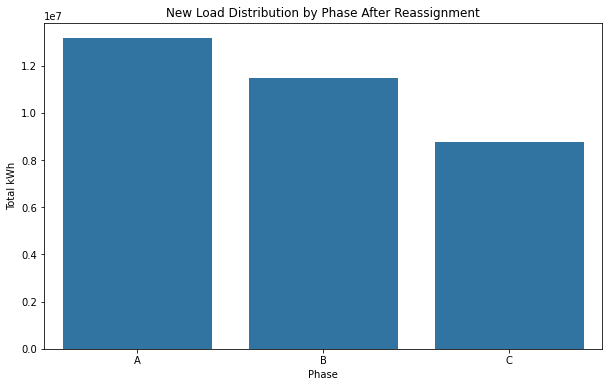

In [3]:
#CLUSTERS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

#GRID
grid_id = 'North Central Zone'
grid_element_id ='12373_hvmv'#'L25A-144657'

# Make Clusters and Fetch Downstream lements
Tree2 = get_ipython().run_line_magic('sql', "SELECT grid_element_id, terminal1_cn, terminal2_cn, phases FROM grid_get_downstream('{grid_id}', '{grid_element_id}')")
Tree2 = Tree2.DataFrame()


BB = Tree2.merge(Tree2, left_on='terminal2_cn', right_on='terminal1_cn', suffixes=('_upper', '_lower'))

# Trace elements where the phases change from ABC to non-ABC
bif = BB[(BB['phases_upper'] == 'ABC') & (BB['phases_lower'] != 'ABC')].reset_index()

# Initialize columns for meter count and total consumption
bif['Meters_in_cluster'] = 0
bif['Total_consumption'] = 0

# Calculate consumption and number of meters in each cluster
for ii in range(len(bif)):
    grid_element_id = bif['grid_element_id_lower'].iloc[ii]
    
    try:
        
        get_ipython().run_line_magic('sql', "CREATE OR REPLACE TEMPORARY VIEW meter_data_source2 AS SELECT meter.grid_id, meter.grid_element_id, geds.grid_element_data_source_id, geds.friendly_id, geds.phases, geds.provider, metric_key as metric, lower(geds.valid) as start_time, upper(geds.valid) as end_time FROM grid_get_downstream('{grid_id}', '{grid_element_id}') AS meter LEFT JOIN grid_element_data_source geds ON meter.grid_element_id = geds.grid_element_id AND meter.grid_id = geds.grid_id AND geds.type = 'CONSUMER' JOIN UNNEST(geds.metrics::TEXT[]) AS metric_key ON true WHERE meter.type = 'Meter';")

        get_ipython().run_line_magic('sql', "CREATE OR REPLACE TEMPORARY VIEW grid_element_metric AS SELECT grid_id, grid_element_id, phases, type, provider, direction, friendly_id, metric_key AS metric, valid, timestamp, value FROM grid_element_data_source geds JOIN UNNEST(geds.metrics::TEXT[]) AS metric_key ON true LEFT JOIN ts_data_source_select(grid_element_data_source_id, metric_key) AS ts ON true;")
        
        get_ipython().run_line_magic('sql', "CREATE OR REPLACE TEMPORARY VIEW meter_consumption2 AS SELECT meter.grid_id, meter.grid_element_id, meter.friendly_id, timestamp, value AS kWh, meter.phases FROM meter_data_source2 meter LEFT JOIN grid_element_metric gem ON gem.grid_id = meter.grid_id AND gem.grid_element_id = meter.grid_element_id WHERE gem.metric = 'kWh' AND gem.type = 'CONSUMER';")

      
        JJ = get_ipython().run_line_magic('sql', 'SELECT COUNT(DISTINCT grid_element_id) FROM meter_data_source2')
        KK = get_ipython().run_line_magic('sql', 'SELECT SUM(kWh) AS kWh FROM meter_consumption2')

        bif.loc[ii, 'Meters_in_cluster'] = JJ[0][0]
        bif.loc[ii, 'Total_consumption'] = KK[0][0]
    except Exception as e:
        print(f"Error processing cluster {grid_element_id}: {e}")
        bif.loc[ii, 'Meters_in_cluster'] = 0
        bif.loc[ii, 'Total_consumption'] = 0


print(bif) #bif

# DataFrame for phase loads for each cluster
phase_loads_df = pd.DataFrame(columns=['grid_element_id', 'phase', 'total_kwh'])

# Calculate phase loads
for ii in range(len(bif)):
    grid_element_id = bif['grid_element_id_lower'].iloc[ii]
    
    try:
       
        get_ipython().run_line_magic('sql', "CREATE OR REPLACE TEMPORARY VIEW meter_data_source2 AS     SELECT meter.grid_id,           meter.grid_element_id,           geds.grid_element_data_source_id,           geds.friendly_id,           geds.phases,           geds.provider,           metric_key as metric,           lower(geds.valid) as start_time,           upper(geds.valid) as end_time    FROM grid_get_downstream('{grid_id}', '{grid_element_id}') AS meter    LEFT JOIN grid_element_data_source geds           ON meter.grid_element_id = geds.grid_element_id           AND meter.grid_id = geds.grid_id           AND geds.type = 'CONSUMER'    JOIN UNNEST(geds.metrics::TEXT[]) AS metric_key           ON true    WHERE meter.type = 'Meter';")

        get_ipython().run_line_magic('sql', "CREATE OR REPLACE TEMPORARY VIEW meter_consumption2 AS    SELECT meter.grid_id,           meter.grid_element_id,           meter.friendly_id,           timestamp,           value AS kWh,           meter.phases    FROM meter_data_source2 meter    LEFT JOIN grid_element_metric gem           ON gem.grid_id = meter.grid_id           AND gem.grid_element_id = meter.grid_element_id    WHERE gem.metric = 'kWh'           AND gem.type = 'CONSUMER';")

       
        query = "SELECT phases AS phase, SUM(kWh) AS total_kwh FROM meter_consumption2 GROUP BY phases"
        phase_consumption = get_ipython().run_line_magic('sql', '$query')
        phase_consumption = phase_consumption.DataFrame()

        
        phase_consumption['grid_element_id'] = grid_element_id

      
        phase_loads_df = pd.concat([phase_loads_df, phase_consumption], ignore_index=True)
    except Exception as e:
        print(f"Error processing cluster {grid_element_id}: {e}")


phase_loads_df['total_kwh'] = phase_loads_df['total_kwh'].astype(float)

print("Phase Loads Data:")
print(phase_loads_df)

# Aggregate loads for each phase across all clusters
total_loads = phase_loads_df.groupby('phase')['total_kwh'].sum().reset_index()
print("Total Loads per Phase:")
print(total_loads)

# Define the Linear Programing (LP) problem
problem = LpProblem("Phase_Balance_Optimization", LpMinimize)

# Decision variables for each phase is a phase load
phase_vars = {phase: LpVariable(f"load_{phase}", 0) for phase in ['A', 'B', 'C']}

# Objective function: Minimize the sum of absolute differences between phases
abs_diff = {(phase, other_phase): LpVariable(f"AbsDiff_{phase}_{other_phase}", 0) 
            for phase in ['A', 'B', 'C'] 
            for other_phase in ['A', 'B', 'C'] if phase != other_phase}
problem += lpSum(abs_diff.values())

# Constraint1: Total load must be preserved
total_load = total_loads['total_kwh'].sum()
for phase in ['A', 'B', 'C']:
    problem += phase_vars[phase] >= 0
    problem += phase_vars[phase] <= total_load  # Upper bound to be realistic

# Ensure total load is preserved across phases
problem += lpSum(phase_vars[phase] for phase in ['A', 'B', 'C']) == total_load

# Constraints for absolute differences
for phase in ['A', 'B', 'C']:
    for other_phase in ['A', 'B', 'C']:
        if phase != other_phase:
            problem += abs_diff[(phase, other_phase)] >= phase_vars[phase] - phase_vars[other_phase]
            problem += abs_diff[(phase, other_phase)] >= phase_vars[other_phase] - phase_vars[phase]


problem.solve()


optimal_loads = {phase: phase_vars[phase].varValue for phase in ['A', 'B', 'C']}
optimal_loads_df = pd.DataFrame(list(optimal_loads.items()), columns=['phase', 'optimal_load'])

print("Optimal Loads:")
print(optimal_loads_df)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='phase', y='optimal_load', data=optimal_loads_df)
plt.title('Optimal Load Distribution by Phase')
plt.xlabel('Phase')
plt.ylabel('Optimal Load (kWh)')
plt.show()

# Calculate the difference between actual and optimal loads
load_diff = total_loads.set_index('phase')['total_kwh'] - optimal_loads_df.set_index('phase')['optimal_load']
print("Load Differences:\n", load_diff)

# Reassign clusters to get the optimal load produced before (with two conditions/constraints)
def reassign_clusters():
    global load_diff, phase_loads_df
    reassignment_count = 0
    max_reassignment_attempts = 1000  # Set a maximum number of reassignment attempts
    improvement_threshold = 0.1  # Minimum improvement to continue reassignments

    previous_total_diff = load_diff.abs().sum()

    while (load_diff.abs() > 0.1).any() and reassignment_count < max_reassignment_attempts:
        for phase in load_diff.index:
            if load_diff[phase] > 0:  # If phase is overloaded
                underloaded_phases = load_diff[load_diff < 0].index.tolist()
                for underloaded_phase in underloaded_phases:
                    # Identify clusters with high load in the overloaded phase
                    high_load_clusters = phase_loads_df[(phase_loads_df['phase'] == phase) & (phase_loads_df['total_kwh'] > 0)]
                    if not high_load_clusters.empty:
                        high_load_cluster = high_load_clusters.iloc[0]
                        cluster_id = high_load_cluster['grid_element_id']
                        load_reassigned = high_load_cluster['total_kwh']
                        
                        if load_diff[phase] >= load_reassigned:
                            # Reassign the cluster to the underloaded phase
                            phase_loads_df.loc[(phase_loads_df['grid_element_id'] == cluster_id) & (phase_loads_df['phase'] == phase), 'phase'] = underloaded_phase
                            print(f"Reassigned cluster {cluster_id} from phase {phase} to phase {underloaded_phase}")
                            # Update load_diff after reassignment
                            load_diff[phase] -= load_reassigned
                            load_diff[underloaded_phase] += load_reassigned
                            reassignment_count += 1
                            if load_diff[underloaded_phase] >= 0:  # Stop if the underloaded phase is balanced
                                break
                    if load_diff[phase] <= 0:  # Stop if the overloaded phase is balanced
                        break
        
        current_total_diff = load_diff.abs().sum()
        improvement = previous_total_diff - current_total_diff
        if improvement < improvement_threshold:  # Stop if the improvement is below the threshold
            print("Improvement below threshold. Stopping reassignments.")
            break

        previous_total_diff = current_total_diff

    print(f"Total cluster reassignments: {reassignment_count}")


reassign_clusters()


print("Updated Load Differences:\n", load_diff)


new_loads = phase_loads_df.groupby('phase')['total_kwh'].sum().astype(float)
print("New Loads:\n", new_loads)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=new_loads.index, y=new_loads.values)
plt.title('New Load Distribution by Phase After Reassignment')
plt.xlabel('Phase')
plt.ylabel('Total kWh')
plt.savefig('new_load_distribution_after_reassignment.png')  
plt.show()
